# 1. Import Libraries

In [1]:
import pandas as pd
import pandas.api.types as ptypes
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import math, os, shutil, datetime
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 500
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for working professionals better. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.

MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp).

MedCamp has conducted 65 such events over a period of 4 years and they see a high drop off between “Registration” and Number of people taking tests at the Camps. In last 4 years, they have stored data of ~110,000 registrations they have done.

One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.

## Process

- MedCamp employees / volunteers reach out to people and drive registrations.
- During the camp, People who “ShowUp” either undergo the medical tests or visit stalls depending on the format of healthcamp.

## Note 

- Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people.
- For a few camps, there was hardware failure, so some information about date and time of registration is lost.
- MedCamp runs 3 formats of these camps. The first and second format provides people with an instantaneous health score. The third format provides information about several health issues through various awareness stalls.

## Favorable outcome:
- For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall.
- You need to predict the chances (probability) of having a favourable outcome.

# Data Description

## Train Data
train.zip contains 6 different csv files apart from the data dictionary as described below:

**Health_Camp_Detail.csv** – File containing Health_Camp_Id, Camp_Start_Date, Camp_End_Date and Category details of each camp.

**Train.csv** – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date.

**Patient_Profile.csv** – This file contains Patient profile details like Patient_ID, Online_Follower, Social media details, Income, Education, Age, First_Interaction_Date, City_Type and Employer_Category

**First_Health_Camp_Attended.csv** – This file contains details about people who attended health camp of first format. This includes Donation (amount) & Health_Score of the person.

**Second_Health_Camp_Attended.csv** - This file contains details about people who attended health camp of second format. This includes Health_Score of the person.

**Third_Health_Camp_Attended.csv** - This file contains details about people who attended health camp of third format. This includes Number_of_stall_visited & Last_Stall_Visited_Number.

## Test Data

**Test.csv** – File containing registration details for all the camps done after 1st April 2006. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date. Participant should make predictions for these patient camp combinations

## Submission File

**sample_submission.csv**

**Patient_ID**: Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

**Health_Camp_ID**: Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

**Outcome**: Predicted probability for having a favourable outcome depending on the format

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from sklearn.metrics import f1_score, auc, plot_confusion_matrix, plot_roc_curve, roc_auc_score

In [5]:
from sklearn.model_selection import cross_val_score

# Load Data

In [6]:
train_data = pd.read_csv('../Data/Train/Train.csv')
firstcamp_data = pd.read_csv('../Data/Train/First_Health_Camp_Attended.csv')
secondcamp_data = pd.read_csv('../Data/Train/Second_Health_Camp_Attended.csv')
thirdcamp_data = pd.read_csv('../Data/Train/Third_Health_Camp_Attended.csv')
healthcamp_data = pd.read_csv('../Data/Train/Health_Camp_Detail.csv')
patient_data = pd.read_csv('../Data/Train/Patient_Profile.csv')

test_data = pd.read_csv('../Data/test_l0Auv8Q.csv')
submission_data = pd.read_csv('../Data/sample_submmission.csv')

# Data Cleaning

In [7]:
train_final_data = pd.merge(train_data, firstcamp_data.drop('Unnamed: 4', axis=1), how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp1_merge_ind')
train_final_data = pd.merge(train_final_data, secondcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp2_merge_ind')
train_final_data = pd.merge(train_final_data, thirdcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp3_merge_ind')
train_final_data = pd.merge(train_final_data, healthcamp_data, how='left', on='Health_Camp_ID', indicator='healthcamp_merge_ind')
train_final_data = pd.merge(train_final_data, patient_data, how='left', on='Patient_ID', indicator='patient_merge_ind')

In [8]:
train_final_data['Outcome'] = 0
train_final_data.loc[(train_final_data['camp1_merge_ind']=='both') | 
                     (train_final_data['camp2_merge_ind']=='both') |
                     ((train_final_data['camp3_merge_ind']=='both') & (train_final_data['Number_of_stall_visited']>0))
                     ,'Outcome'] = 1

In [9]:
test_final_data = pd.merge(test_data, firstcamp_data.drop('Unnamed: 4', axis=1), how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp1_merge_ind')
test_final_data = pd.merge(test_final_data, secondcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp2_merge_ind')
test_final_data = pd.merge(test_final_data, thirdcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp3_merge_ind')
test_final_data = pd.merge(test_final_data, healthcamp_data, how='left', on='Health_Camp_ID', indicator='healthcamp_merge_ind')
test_final_data = pd.merge(test_final_data, patient_data, how='left', on='Patient_ID', indicator='patient_merge_ind')

In [10]:
date_cols = ['Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']

In [11]:
def to_date(df):
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%d-%b-%y')
    return df

In [12]:
train_final_data = to_date(train_final_data)
test_final_data = to_date(test_final_data)

In [13]:
num_cols = ['Income', 'Education_Score', 'Age']

In [14]:
def to_numeric(df, columns):
    for col in df.columns:
        if (col in num_cols) & ~(ptypes.is_numeric_dtype(df[col])):
            df[col] = df[col].replace({'None':''})
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [15]:
train_final_data = to_numeric(train_final_data, num_cols)
test_final_data = to_numeric(test_final_data, num_cols)

## Drop unnecessary columns

In [16]:
unnec_cols = ['camp1_merge_ind', 'camp2_merge_ind', 'camp3_merge_ind', 'healthcamp_merge_ind', 'patient_merge_ind']

In [17]:
train_final_data = train_final_data.drop(unnec_cols, axis=1)
test_final_data = test_final_data.drop(unnec_cols, axis=1)

## Missing Imputations

In [18]:
from sklearn.impute import SimpleImputer

### Mean Imputation

In [19]:
mean_impute_cols = ['Age']
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(train_final_data[mean_impute_cols])
train_final_data[mean_impute_cols] = imp_mean.transform(train_final_data[mean_impute_cols])
test_final_data[mean_impute_cols] = imp_mean.transform(test_final_data[mean_impute_cols])

### Frequent Imputation

In [20]:
freq_impute_cols = ['Income', 'Education_Score', 'City_Type', 'Employer_Category']
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(train_final_data[freq_impute_cols])
train_final_data[freq_impute_cols] = imp_freq.transform(train_final_data[freq_impute_cols])
test_final_data[freq_impute_cols] = imp_freq.transform(test_final_data[freq_impute_cols])

### Zero Imputation

In [21]:
zero_impute_cols = ['Donation', 'Health_Score', 'Health Score', 'Number_of_stall_visited', 'Last_Stall_Visited_Number']
train_final_data[zero_impute_cols] = train_final_data[zero_impute_cols].fillna(0)
test_final_data[zero_impute_cols] = test_final_data[zero_impute_cols].fillna(0)

## Constants

In [22]:
ID1 = 'Patient_ID'
ID2 = 'Health_Camp_ID'
target = 'Outcome'
date_columns = ['Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']
discrete_columns = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Category1', 'Category2', 'Category3', 'Online_Follower', 
                   'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'City_Type', 'Employer_Category']

In [23]:
train_final_data.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
       'Var3', 'Var4', 'Var5', 'Donation', 'Health_Score', 'Health Score',
       'Number_of_stall_visited', 'Last_Stall_Visited_Number',
       'Camp_Start_Date', 'Camp_End_Date', 'Category1', 'Category2',
       'Category3', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared',
       'Facebook_Shared', 'Income', 'Education_Score', 'Age',
       'First_Interaction', 'City_Type', 'Employer_Category', 'Outcome'],
      dtype='object')

In [24]:
random_state = 1234

In [25]:
should_ohe = True
should_scale = True

## Scaling

In [26]:
if should_scale:
    for col in train_final_data.columns:
        if (col != target) and (col != ID1) and (col != ID2) and (col not in date_columns) and (col not in discrete_columns):
            mms = MinMaxScaler()
            ss = StandardScaler()
            rs = RobustScaler()
            pt = PowerTransformer()
            ft_log = FunctionTransformer(np.log)
            
            train_final_data[f"{col}_MMS"] = mms.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_MMS"] = mms.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_SS"] = ss.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_SS"] = ss.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_RS"] = rs.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_RS"] = rs.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_PT"] = pt.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_PT"] = pt.transform(test_final_data[[col]])
            
#             train_final_data[f"{col}_FT_log"] = ft_log.fit_transform(train_final_data[[col]])
#             test_final_data[f"{col}_FT_log"] = ft_log.transform(test_final_data[[col]])

## One hot encoding

In [27]:
train_final_data['is_train'] = True
test_final_data['is_train'] = False

In [28]:
cols_for_ohe = ['Category1', 'Category2', 'City_Type', 'Employer_Category']

In [29]:
train_final_data = pd.concat([train_final_data.drop(cols_for_ohe,axis=1),pd.get_dummies(train_final_data[cols_for_ohe])],axis=1)
test_final_data = pd.concat([test_final_data.drop(cols_for_ohe,axis=1),pd.get_dummies(test_final_data[cols_for_ohe])],axis=1)

# Test Train Split

In [30]:
from sklearn.model_selection import train_test_split

In [32]:
ignore_cols_train = [ID1, ID2, target, 'Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']
ignore_cols_test = [ID1, ID2, 'Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']
X, y = train_final_data.drop(ignore_cols_train, axis=1), train_final_data[target]
X_test = test_final_data.drop(ignore_cols_test, axis=1)

In [33]:
sum(X_test.isna().sum())

0

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=random_state)

# Base Models

In [35]:
n_esitmators = 1000
classifiers = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=n_esitmators, random_state=random_state),
    "GBM": GradientBoostingClassifier(n_estimators=n_esitmators, random_state=random_state),
    "GBM_ES": GradientBoostingClassifier(n_estimators=n_esitmators, validation_fraction=0.2, 
                                         n_iter_no_change=5,tol=0.01,random_state=random_state)
}

In [36]:
classifiers.items()

dict_items([('DT', DecisionTreeClassifier()), ('RF', RandomForestClassifier(n_estimators=1000, random_state=1234)), ('GBM', GradientBoostingClassifier(n_estimators=1000, random_state=1234)), ('GBM_ES', GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=5,
                           random_state=1234, tol=0.01,
                           validation_fraction=0.2))])

1 Building DT starts..
	 Mean ROC AUC: 1.0 +/- 0.0
	 ROC AUC: 1.0
It took 0:00:04.323908 time to finish the modelling
1 Building DT starts..
2 Building RF starts..
	 Mean ROC AUC: 1.0 +/- 4.965068306494546e-17
	 ROC AUC: 1.0
It took 0:01:27.526565 time to finish the modelling
2 Building RF starts..
3 Building GBM starts..
	 Mean ROC AUC: 1.0 +/- 0.0
	 ROC AUC: 1.0
It took 0:08:06.246064 time to finish the modelling
3 Building GBM starts..
4 Building GBM_ES starts..
	 Mean ROC AUC: 1.0 +/- 0.0
	 ROC AUC: 1.0
It took 0:00:41.029583 time to finish the modelling
4 Building GBM_ES starts..


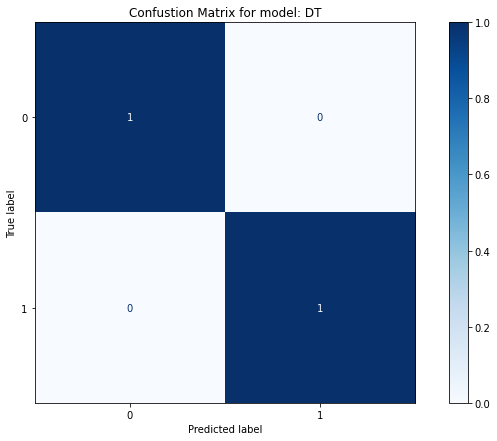

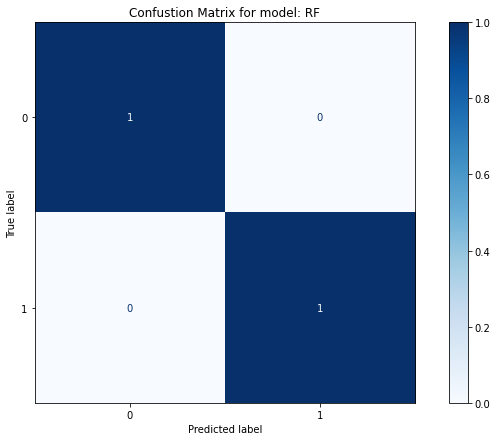

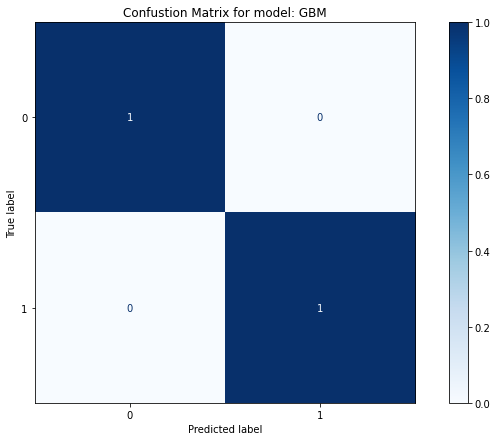

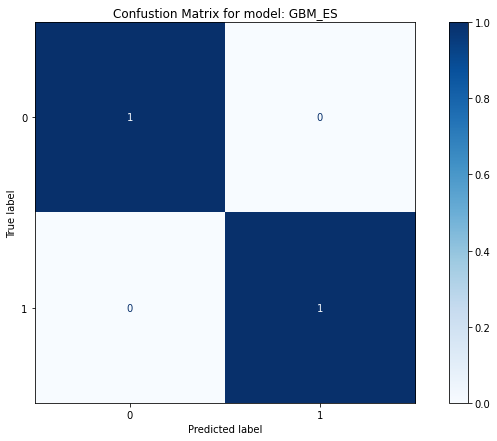

In [37]:
clf_ct=0
for model_name,clf in classifiers.items():
    print(f"{clf_ct+1} Building {model_name} starts..")
    start_ts = datetime.datetime.now()
    
    cv_scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)
    print(f"\t Mean ROC AUC: {np.mean(cv_scores)} +/- {np.std(cv_scores)}")
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    auc_score = roc_auc_score(y_val, predictions)
    print(f"\t ROC AUC: {auc_score}")
    
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    disp = plot_confusion_matrix(clf, X_val, y_val, normalize='true', ax=ax, cmap=plt.cm.Blues)
    disp.ax_.set_title(f"Confustion Matrix for model: {model_name}")
    os.makedirs("../plots/confusion_matrix_scale_ohe",exist_ok=True)
    plt.savefig(f"../plots/confusion_matrix_scale_ohe/{model_name}.png", dpi=300)
    end_ts = datetime.datetime.now()
    
    print(f"It took {end_ts - start_ts} time to finish the modelling")
    print(f"{clf_ct+1} Building {model_name} starts..")
    
    clf_ct+=1
    

In [38]:
sum(train_final_data.isna().sum())

334

In [42]:
var_imp = pd.DataFrame({'var':X.columns, 'var_imp':classifiers['GBM'].feature_importances_})

In [45]:
var_imp.sort_values('var_imp', ascending=False).head(30)

,var,var_imp
26,Health Score_MMS,1.067444e-01
27,Health Score_SS,1.023807e-01
8,Number_of_stall_visited,7.970635e-02
23,Health_Score_SS,7.574836e-02
18,Donation_MMS,7.558934e-02
35,Last_Stall_Visited_Number_SS,7.409523e-02
28,Health Score_RS,7.290320e-02
5,Donation,6.664203e-02
31,Number_of_stall_visited_SS,4.715563e-02
19,Donation_SS,4.256818e-02


In [40]:
X.columns

Index(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Donation', 'Health_Score',
       'Health Score', 'Number_of_stall_visited', 'Last_Stall_Visited_Number',
       'Category3', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared',
       'Facebook_Shared', 'Income', 'Education_Score', 'Age', 'Donation_MMS',
       'Donation_SS', 'Donation_RS', 'Donation_PT', 'Health_Score_MMS',
       'Health_Score_SS', 'Health_Score_RS', 'Health_Score_PT',
       'Health Score_MMS', 'Health Score_SS', 'Health Score_RS',
       'Health Score_PT', 'Number_of_stall_visited_MMS',
       'Number_of_stall_visited_SS', 'Number_of_stall_visited_RS',
       'Number_of_stall_visited_PT', 'Last_Stall_Visited_Number_MMS',
       'Last_Stall_Visited_Number_SS', 'Last_Stall_Visited_Number_RS',
       'Last_Stall_Visited_Number_PT', 'Income_MMS', 'Income_SS', 'Income_RS',
       'Income_PT', 'Education_Score_MMS', 'Education_Score_SS',
       'Education_Score_RS', 'Education_Score_PT', 'Age_MMS', 'Age_SS',
       'Ag